## Stock Price Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

In [2]:
df = pd.read_csv('stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11291 entries, 1980-03-17 to 2024-12-27
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11291 non-null  int64  
 1   Adj Close   11198 non-null  float64
 2   Close       11174 non-null  float64
 3   High        11196 non-null  float64
 4   Low         11164 non-null  float64
 5   Open        11188 non-null  float64
 6   Volume      11146 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 705.7 KB


In [3]:
df.head()

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
1980-03-17,0,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1980-03-18,1,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
1980-03-19,2,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
1980-03-20,3,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
1980-03-21,4,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [4]:
df.describe()

,Unnamed: 0,Adj Close,Close,High,Low,Open,Volume
count,11291.000000,11198.000000,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,5645.000000,63.609130,72.026945,72.503100,71.665079,67.999259,2.144157e+05
std,3259.575279,52.266247,51.259828,51.550735,51.011632,55.834401,3.883662e+05
min,0.000000,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,2822.500000,19.224636,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,5645.000000,50.608900,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,8467.500000,104.723621,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,11290.000000,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07


In [5]:
df.isnull().sum()

Unnamed: 0      0
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64

In [6]:
# Filling missing values with the median of the column
df.fillna(method='ffill', inplace=True)

C:\Users\locha\AppData\Local\Temp\ipykernel_26760\3045657660.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [7]:
df.isnull().sum()

Unnamed: 0    0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
dtype: int64

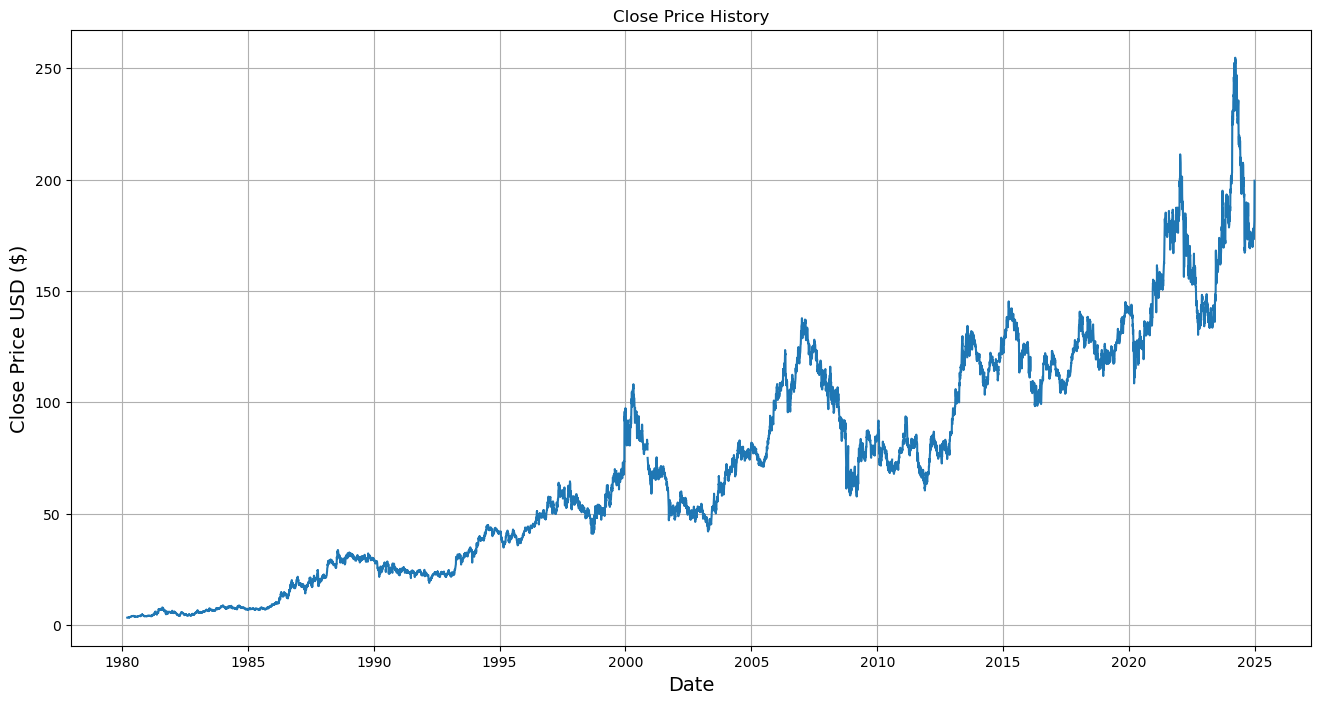

In [8]:
#Visulaize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.grid()
plt.savefig('close_price_history.png')
plt.show()

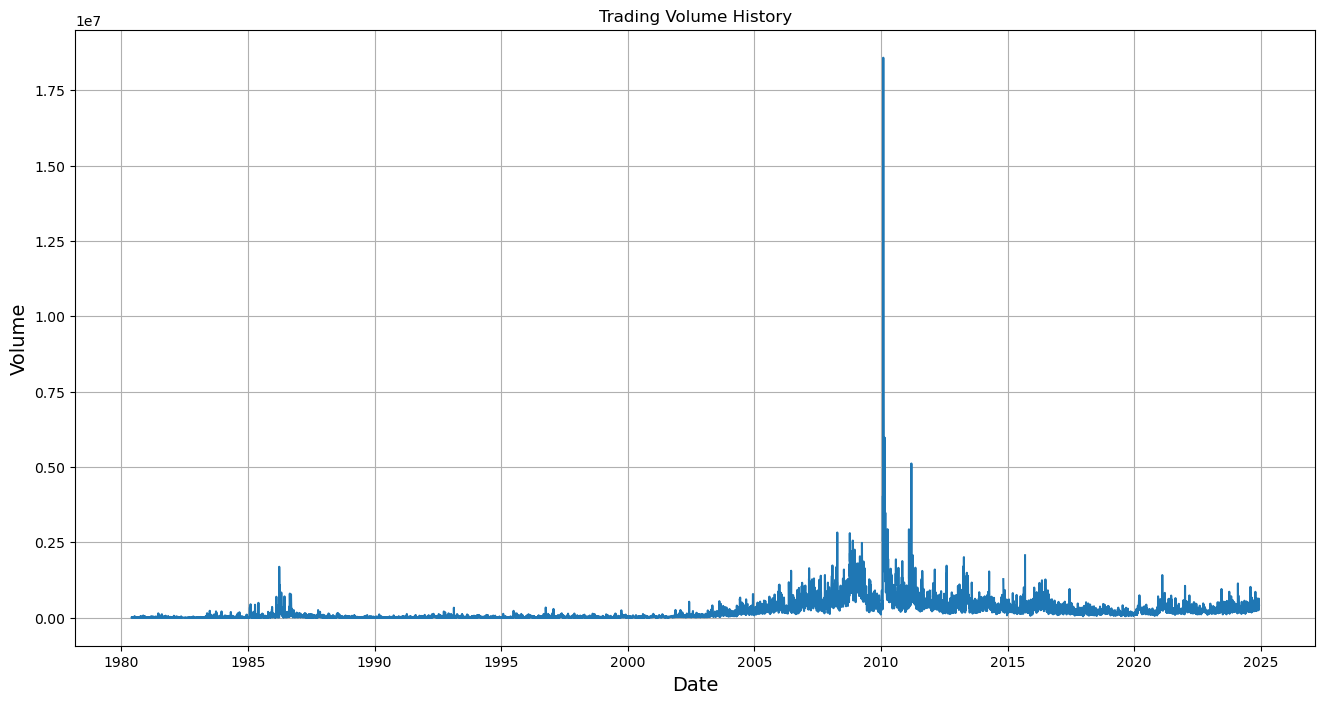

In [58]:
#Visualize the trading volume history
plt.figure(figsize=(16,8))
plt.title('Trading Volume History')
plt.plot(df['Volume'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.savefig('trading_volume_history.png')
plt.show()

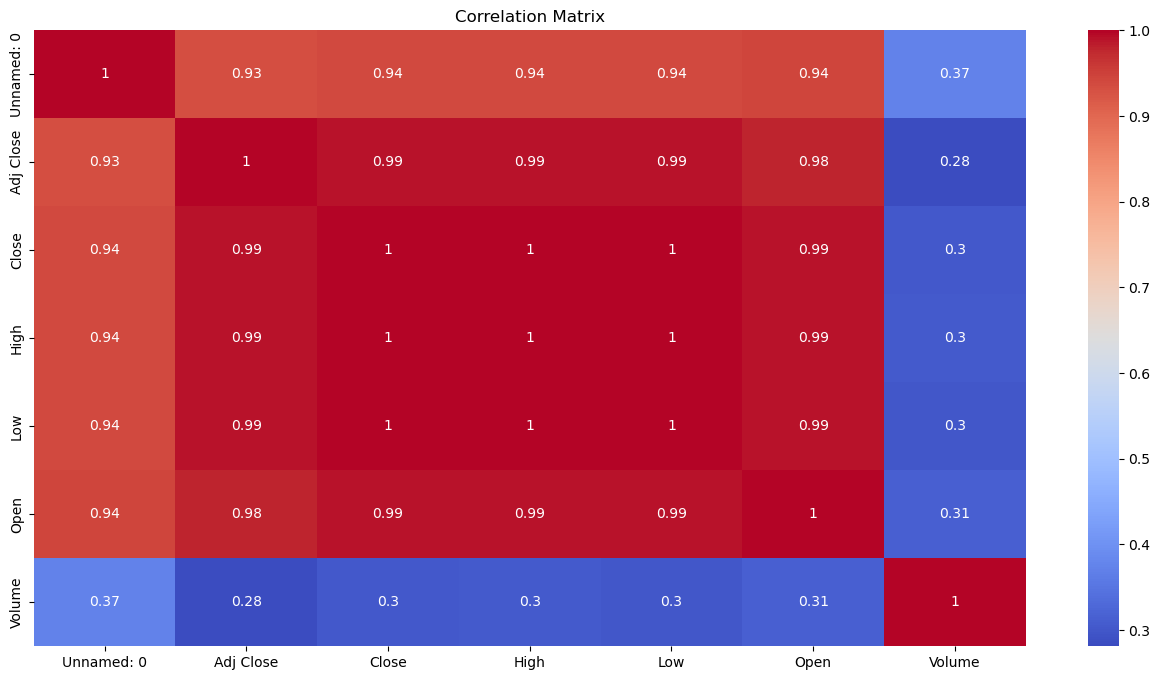

In [9]:
#Correlation matrix
corr = df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

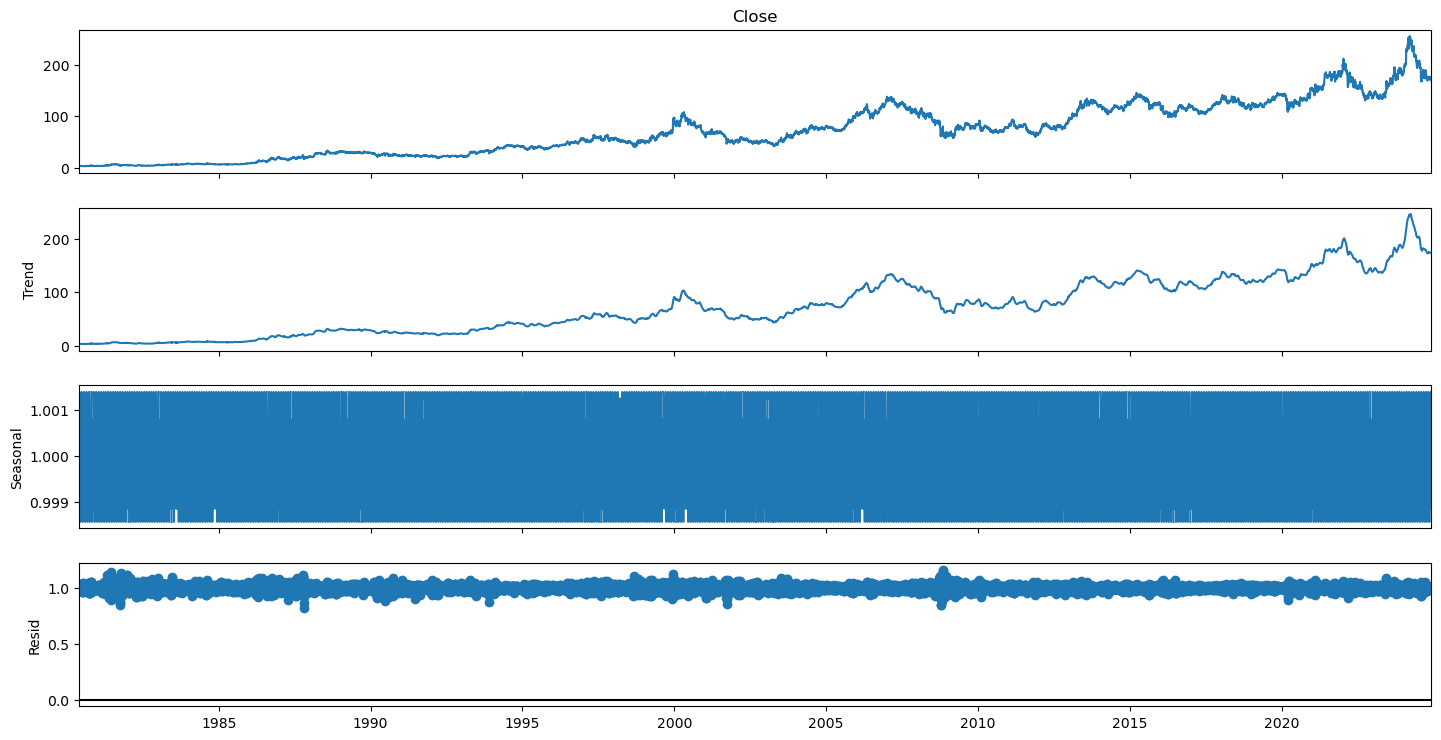

In [56]:
# Trends and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Fill missing values in 'Close' column
df['Close'] = df['Close'].interpolate(method='linear')

decompose = seasonal_decompose(df['Close'], model='multiplicative', period=20)
fig = decompose.plot()
fig.set_size_inches(16,8)
plt.savefig('trends_seasonal.png')
plt.show()

In [11]:
#Check for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}:{value}')

ADF Statistic: -0.46737151245213887
p-value: 0.898227998570021
Critical Values:
1%:-3.4309306294476727
5%:-2.8617966068504166
10%:-2.5669065867160596


### Feature Engineering

In [ ]:
# Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Moving average crossovers
df['MA5_20_Cross'] = (df['MA5'] > df['MA20']).astype(int)
df['MA20_50_Cross'] = (df['MA20'] > df['MA50']).astype(int)

# Distance from moving averages 
df['Dist_MA20'] = (df['Close'] - df['MA20']) / df['MA20']
df['Dist_MA50'] = (df['Close'] - df['MA50']) / df['MA50']

# Price momentum
df['Momentum'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
df['Momentum_20'] = df['Close'] - df['Close'].shift(20)

# Price rate of change at different timeframes
df['ROC_5'] = df['Close'].pct_change(periods=5) * 100
df['ROC_10'] = df['Close'].pct_change(periods=10) * 100
df['ROC_20'] = df['Close'].pct_change(periods=20) * 100

In [14]:
# Drop NaN values created by the indicators
df.dropna(inplace=True)

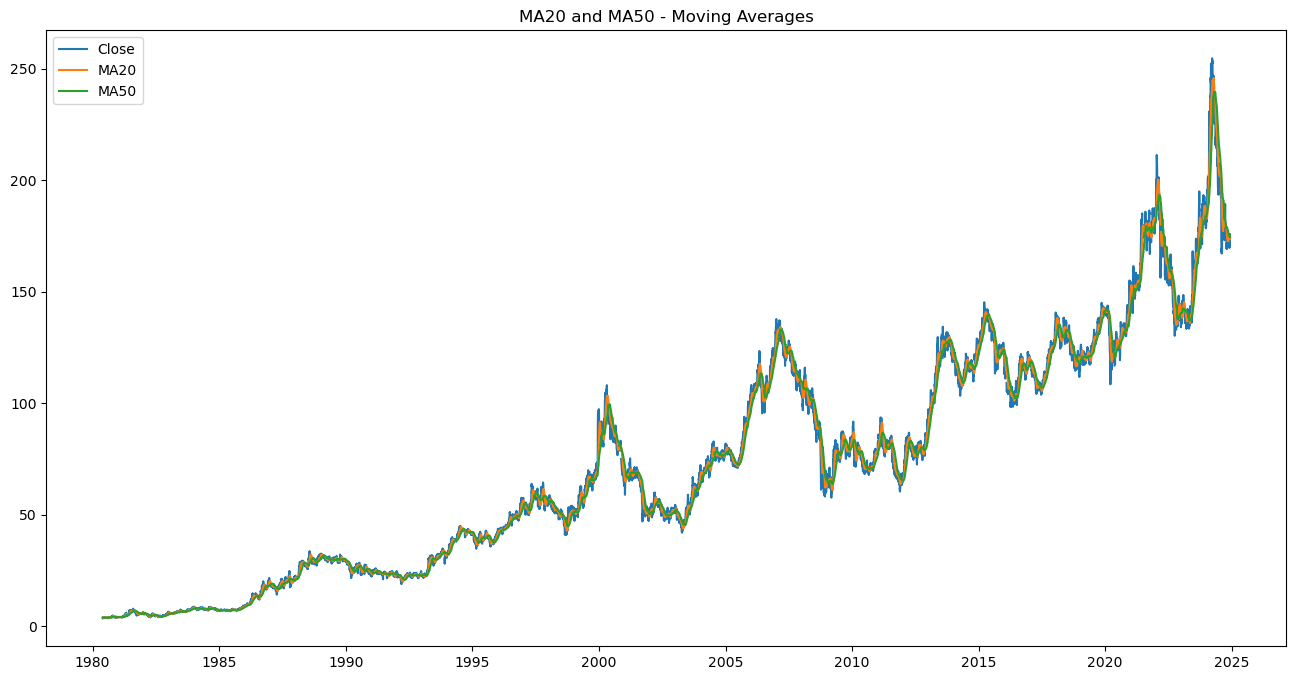

In [57]:
# Visualize the new features
plt.figure(figsize=(16, 8))
plt.title('MA20 and MA50 - Moving Averages')
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.plot(df['MA50'], label='MA50')
plt.legend()
plt.savefig('MA20_MA50.png')
plt.show()

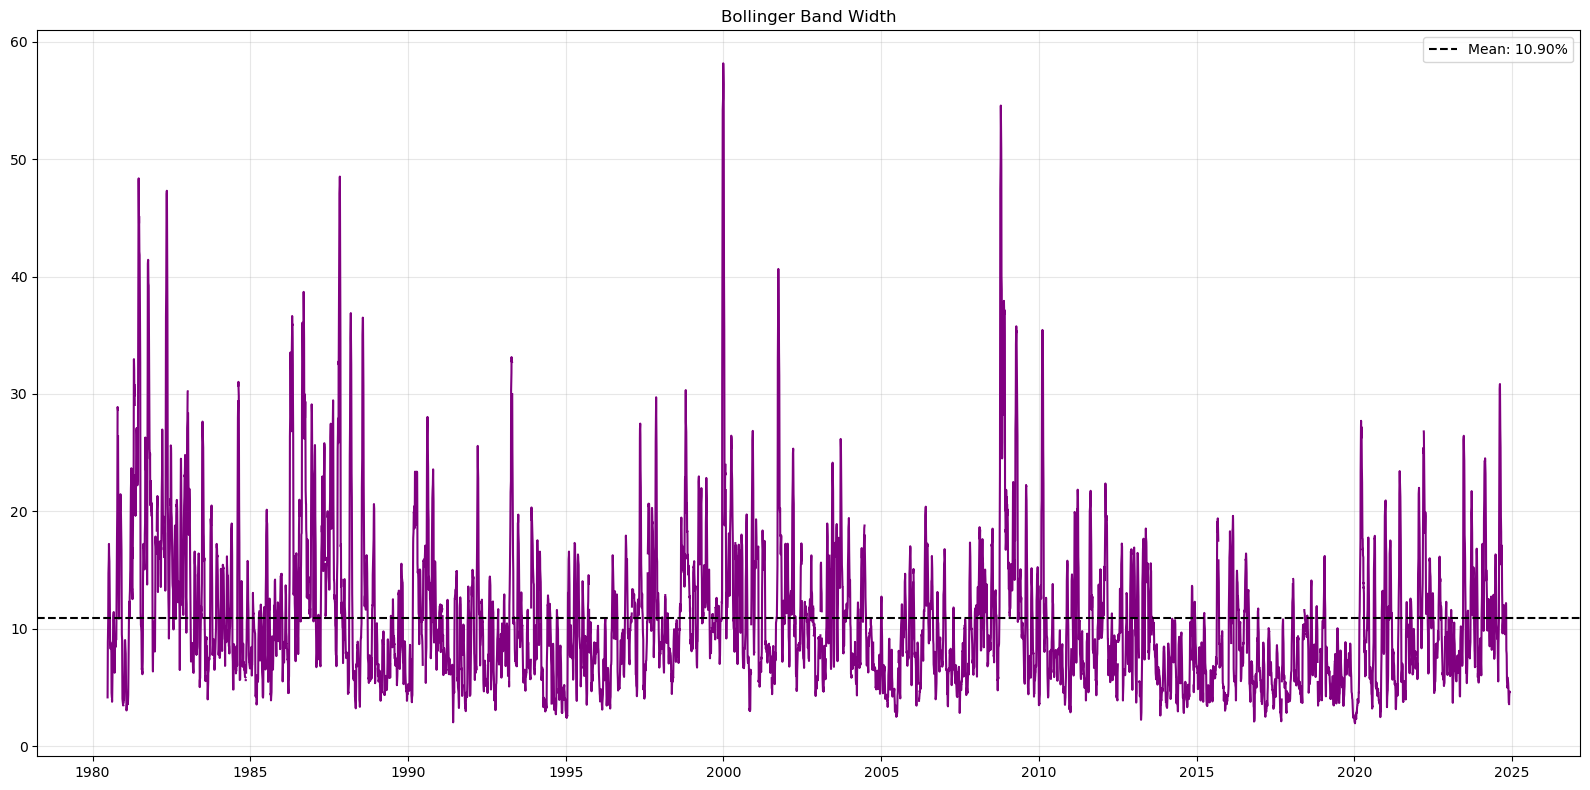

In [51]:
# Bollinger Bands and Band Width
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['SMA20'] + (df['STD20'] * 2)
df['Lower_Band'] = df['SMA20'] - (df['STD20'] * 2)
df['Band_Width'] = ((df['Upper_Band'] - df['Lower_Band']) / df['SMA20']) * 100

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Band_Width'], color='purple')
plt.axhline(y=df['Band_Width'].mean(), color='black', linestyle='--', 
           label=f'Mean: {df["Band_Width"].mean():.2f}%')
plt.title('Bollinger Band Width')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bollinger_bands.png')
plt.show()

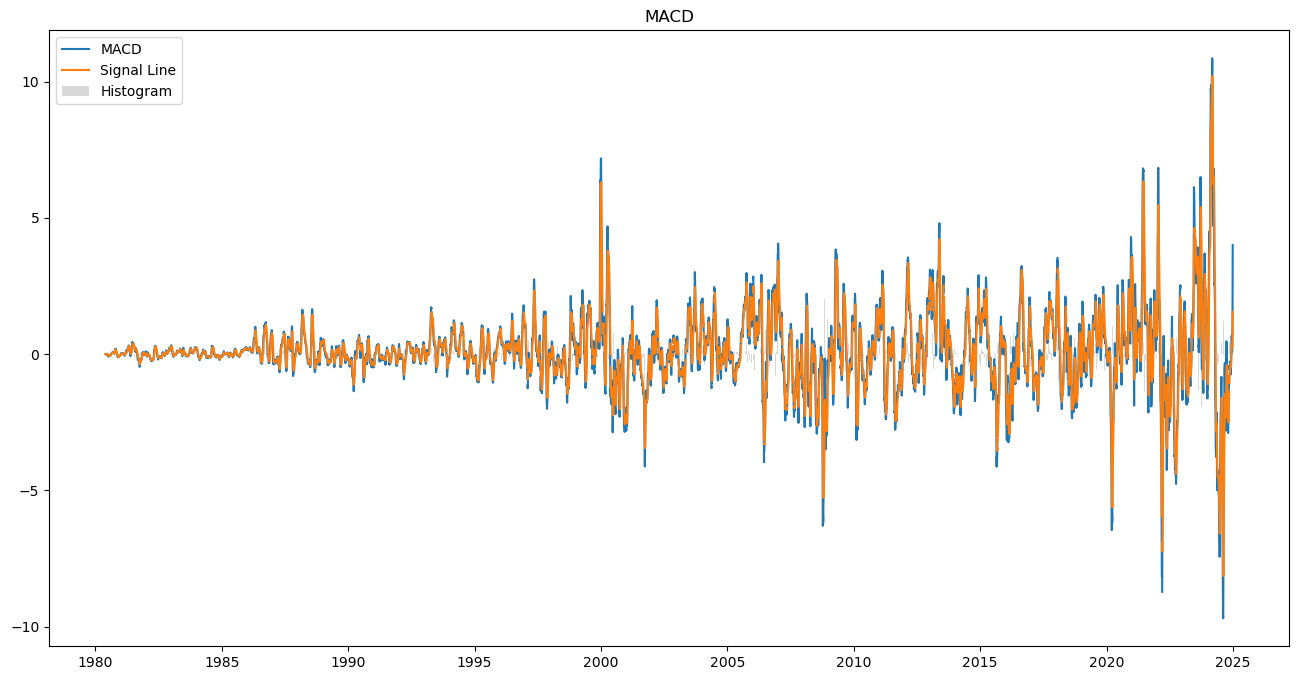

In [ ]:
# MACD indicator
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# Visualize MACD
plt.figure(figsize=(16, 8))
plt.title('MACD')
plt.plot(df['MACD'], label='MACD')
plt.plot(df['MACD_Signal'], label='Signal Line')
plt.bar(df.index, df['MACD_Hist'], color='gray', alpha=0.3, label='Histogram')
plt.legend()
plt.savefig('macd.png')
plt.show()

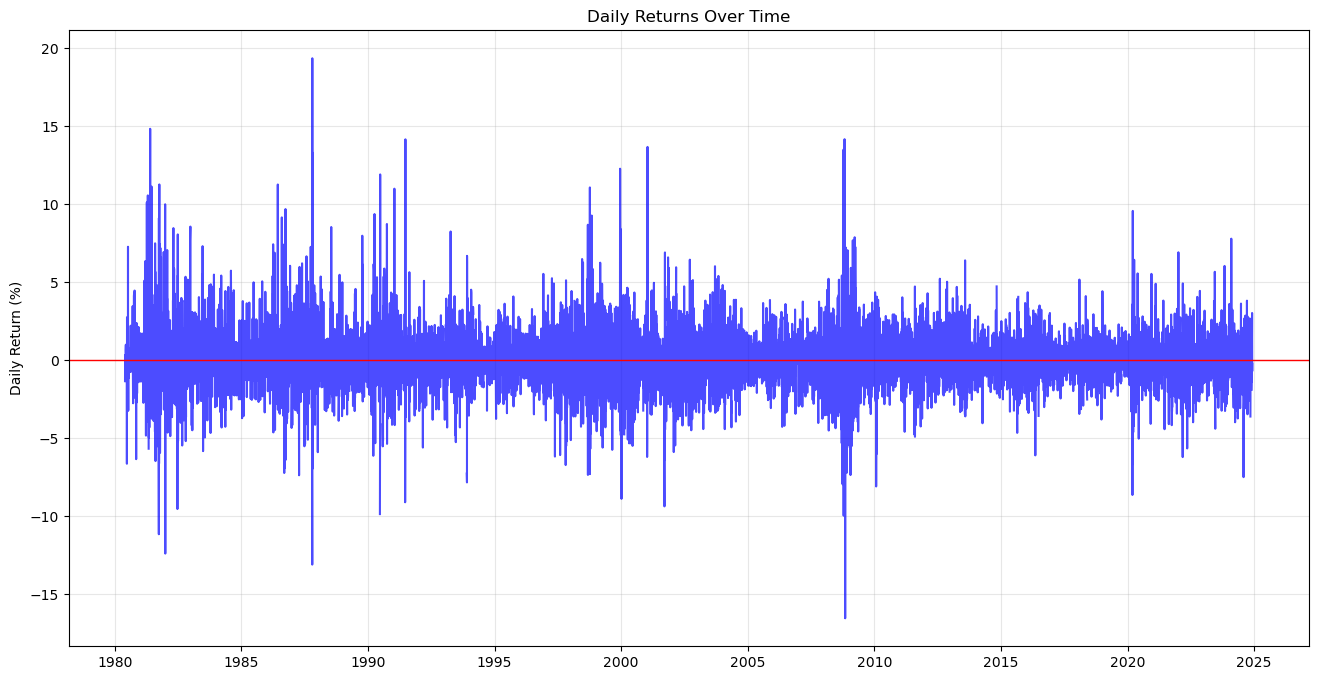

In [54]:
# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100

# Daily returns time series
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Daily_Return'], color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='-', linewidth=1)
plt.title('Daily Returns Over Time')
plt.ylabel('Daily Return (%)')
plt.grid(True, alpha=0.3)
plt.savefig('daily_returns.png')
plt.show()

### Data prepaeration for LSTM 

In [ ]:
# Define the target variable: 5-day future closing price
df['Target'] = df['Close'].shift(-5)  
df.dropna(inplace=True)  

# Select features
features = ['Close', 'High', 'Low', 'Volume', 'MA5', 'MA20', 'Momentum', 'Volatility', 'MACD',
            'MACD_Signal', 'MA5_20_Cross', 'MA20_50_Cross', 'Dist_MA20', 'Dist_MA50',
            'ROC_5', 'ROC_10', 'ROC_20']
X = df[features].values
y = df['Target'].values

In [21]:
# Split data into training and testing sets (keeping time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [22]:
# Normalize the data 
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

In [ ]:
# Sequences for LSTM input 
def create_sequences(X, y, time_steps=20):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 20 
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

In [ ]:
# Check the shapes
print(f"X_train_seq shape: {X_train_seq.shape}")  
print(f"y_train_seq shape: {y_train_seq.shape}") 

X_train_seq shape: (8961, 20, 17)
y_train_seq shape: (8961, 1)


#### Build the model

In [25]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting a single value (close price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\locha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        13,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,851 (132.23 KB)

 Trainable params: 33,851 (132.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Print input shapes 
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")

# Rebuild the model 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

X_train_seq shape: (8961, 20, 17)
y_train_seq shape: (8961, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        13,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,851 (132.23 KB)

 Trainable params: 33,851 (132.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0082 - val_loss: 0.0023
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - val_loss: 7.8977e-04
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - val_loss: 8.4342e-04
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - val_loss: 7.3993e-04
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010 - val_loss: 8.3213e-04
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.4202e-04 - val_loss: 0.0011
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.9304e-04 - val_loss: 7.3619e-04
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.0001e-04 - val_loss: 0.0015
Epoch 12

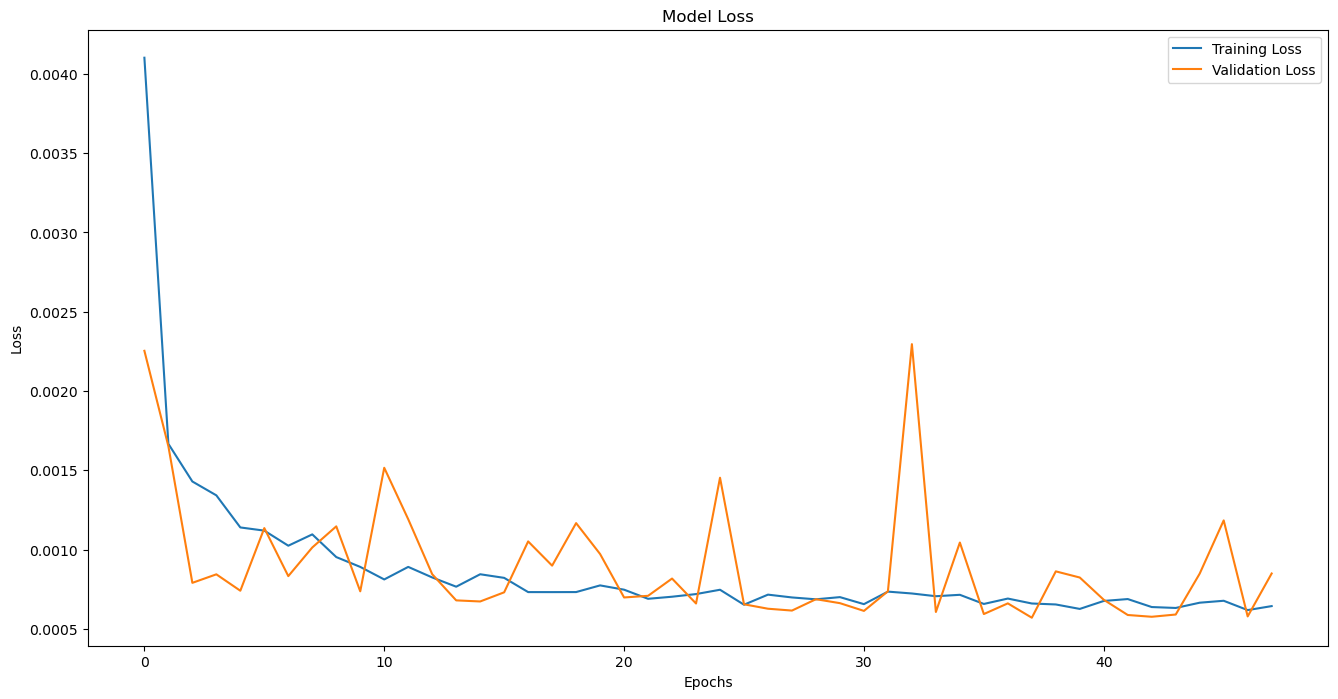

In [27]:
# Plot training history
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model_training_history.png')
plt.show()

In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test_seq)

# Check shapes
print(f"y_pred_scaled shape: {y_pred_scaled.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

# Take the first value
if len(y_pred_scaled.shape) > 2 or (len(y_pred_scaled.shape) == 2 and y_pred_scaled.shape[1] > 1):
	y_pred_scaled = y_pred_scaled[:, 0].reshape(-1, 1)

# Inverse transform to get actual price values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_actual = y_scaler.inverse_transform(y_test_seq)

# Error metrics
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}%')

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
y_pred_scaled shape: (2226, 1)
y_test_seq shape: (2226, 1)
Root Mean Squared Error: 13.989590140729089
Mean Absolute Error: 8.262120003066062
Mean Absolute Percentage Error: 4.773783937434648%


In [ ]:
# Calculate directional accuracy 
y_test_direction = np.diff(y_test_actual.flatten())
y_pred_direction = np.diff(y_pred.flatten())
directional_accuracy = np.mean((y_test_direction > 0) == (y_pred_direction > 0)) * 100
print(f'Directional Accuracy: {directional_accuracy}%')

Directional Accuracy: 51.5056179775281%


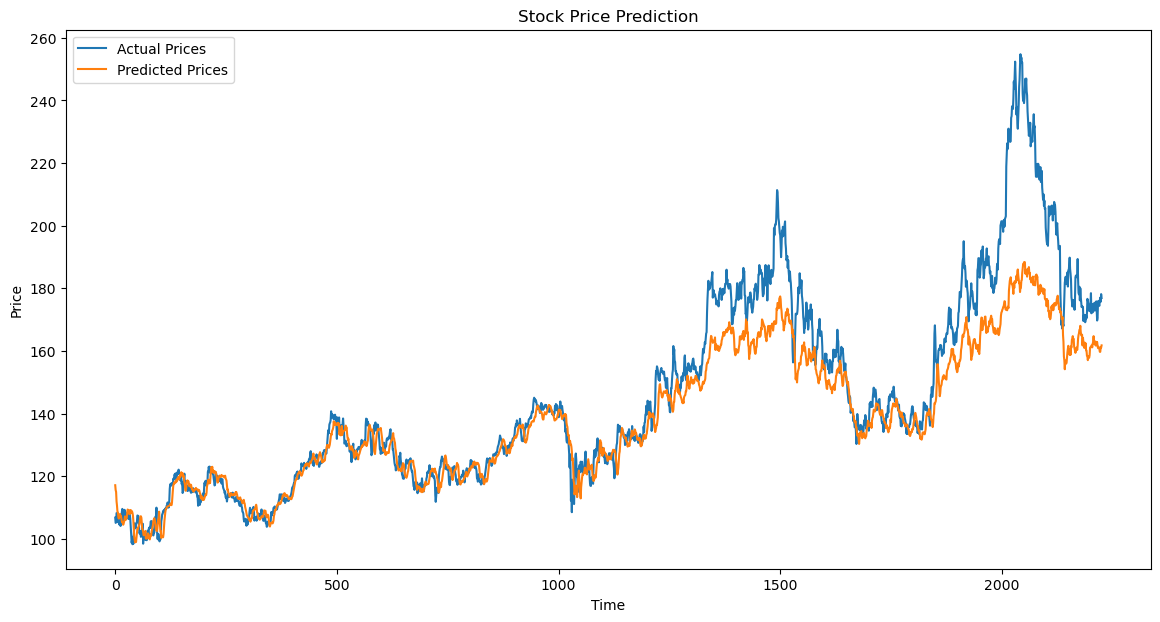

In [ ]:
# Predictions vs Actual values
plt.figure(figsize=(14, 7))
plt.title('Stock Price Prediction')
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('prediction_vs_actual.png')
plt.show()

In [31]:
# Calculate trading performance
initial_capital = 10000
position = 0
portfolio_value = [initial_capital]
returns = []

In [32]:
# Simple trading strategy: Buy when predicted price increases, sell when predicted price decreases
for i in range(1, len(y_pred)):
    # Predicted price change
    price_change = y_pred[i] - y_pred[i-1]
    
    if price_change > 0 and position == 0:  # Buy signal
        position = portfolio_value[-1] / y_test_actual[i]
        portfolio_value.append(portfolio_value[-1])  # No change until we sell
    elif price_change < 0 and position > 0:  # Sell signal
        portfolio_value.append(position * y_test_actual[i])
        position = 0
    else:
        if position > 0:  # If holding position, update portfolio value
            portfolio_value.append(position * y_test_actual[i])
        else:
            portfolio_value.append(portfolio_value[-1])
    
    returns.append((portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2])

In [33]:
# Calculate trading metrics
cumulative_return = (portfolio_value[-1] - initial_capital) / initial_capital * 100
annualized_return = (1 + (portfolio_value[-1] - initial_capital) / initial_capital) ** (252 / len(y_pred)) - 1
sharpe_ratio = np.mean([r.item() if isinstance(r, np.ndarray) else r for r in returns]) / np.std([r.item() if isinstance(r, np.ndarray) else r for r in returns]) * np.sqrt(252)
max_drawdown = np.max(np.maximum.accumulate([pv.item() if isinstance(pv, np.ndarray) else pv for pv in portfolio_value]) - [pv.item() if isinstance(pv, np.ndarray) else pv for pv in portfolio_value]) / np.max([pv.item() if isinstance(pv, np.ndarray) else pv for pv in portfolio_value])

# Extract scalar values from numpy arrays
cumulative_return = cumulative_return.item() if isinstance(cumulative_return, np.ndarray) else cumulative_return
annualized_return = annualized_return.item() if isinstance(annualized_return, np.ndarray) else annualized_return
sharpe_ratio = sharpe_ratio.item() if isinstance(sharpe_ratio, np.ndarray) else sharpe_ratio
max_drawdown = max_drawdown.item() if isinstance(max_drawdown, np.ndarray) else max_drawdown

print(f'Cumulative Return: {cumulative_return:.2f}%')
print(f'Annualized Return: {annualized_return:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown:.2f}')

Cumulative Return: 36.98%
Annualized Return: 0.04%
Sharpe Ratio: 0.31
Maximum Drawdown: 0.18


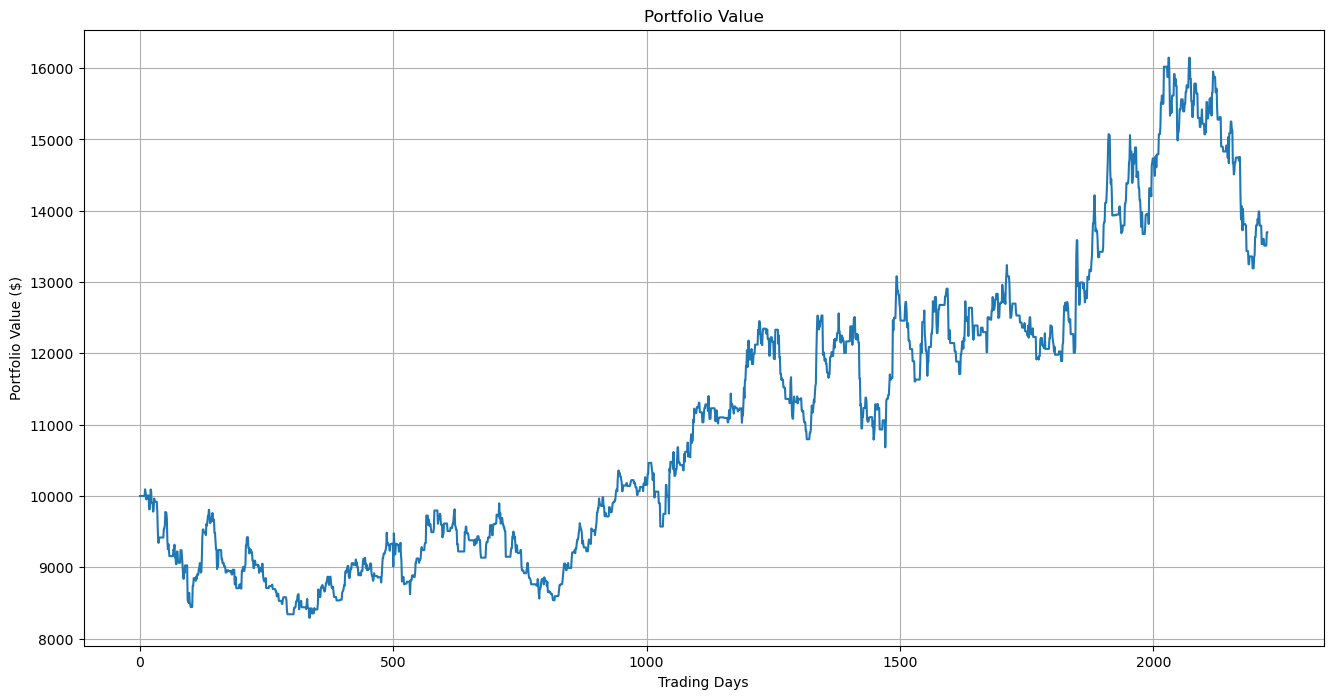

In [34]:
# Convert any numpy arrays in portfolio_value to scalar values
portfolio_value = [pv.item() if isinstance(pv, np.ndarray) else pv for pv in portfolio_value]

# Plot portfolio value over time
plt.figure(figsize=(16, 8))
plt.title('Portfolio Value')
plt.plot(portfolio_value)
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.savefig('portfolio_performance.png')
plt.show()

### Feature Importance Analysis

In [38]:
from sklearn.inspection import permutation_importance

# Make predictions and calculate RMSE
def predict_and_score(model, X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y, y_pred)  

baseline_score = predict_and_score(model, X_test_seq, y_test_seq)

importance_scores = {}

# Print the baseline score
print(f"Baseline score: {baseline_score:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Baseline score: -0.0098


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


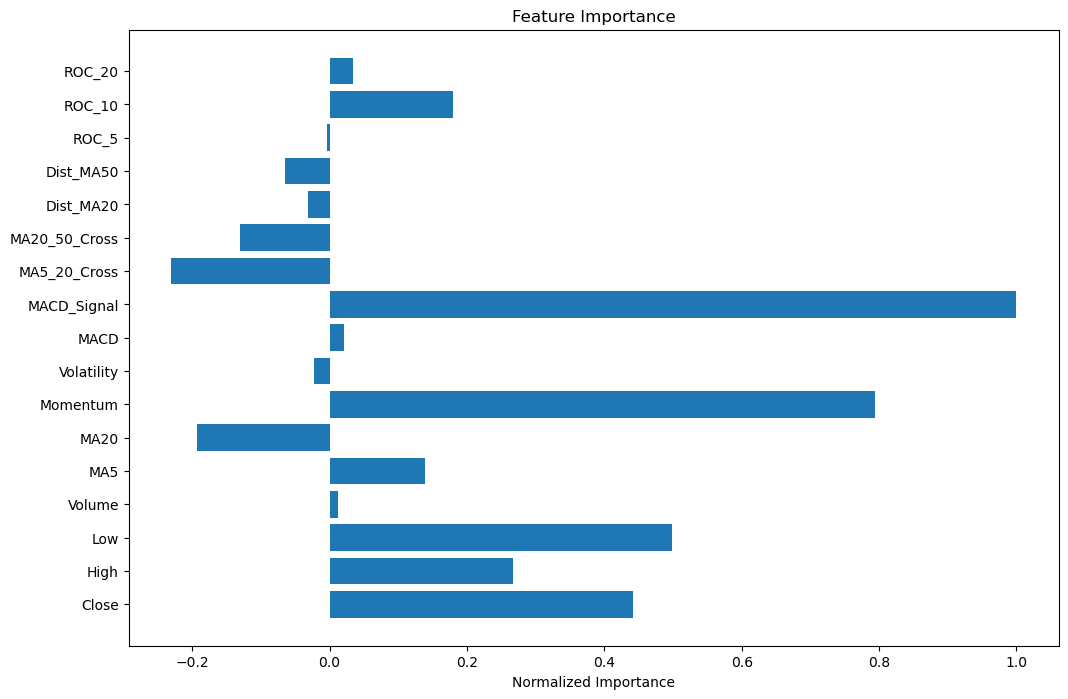

In [40]:
# For each feature, permute its values and measure the impact
for i in range(X_train_seq.shape[2]):
    # Make a copy of the test data
    X_permuted = X_test_seq.copy()
    
    # Shuffle the values of the current feature across all sequences
    for j in range(X_test_seq.shape[0]):
        np.random.shuffle(X_permuted[j, :, i])
    
    # Calculate new score with permuted feature
    new_score = predict_and_score(model, X_permuted, y_test_seq)
    
    # The importance is the difference in scores
    importance = baseline_score - new_score
    importance_scores[features[i]] = importance

# Normalize importances
max_importance = max(importance_scores.values())
for feature in importance_scores:
    importance_scores[feature] /= max_importance

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(list(importance_scores.keys()), list(importance_scores.values()))
plt.xlabel('Normalized Importance')
plt.title('Feature Importance')
plt.savefig('feature_importance.png')
plt.show()


### Limitation Analysis and Improvement Strategies

#### 1.Model Limitations
* Limited feature interaction: The current model may not fully capture complex interactions between features.

* Temporal understanding: The model may struggle with long-term dependencies in sequential data.

* Overfitting risk: Complex models on limited data may memorize rather than generalize.

* Feature importance variability: Rankings may change with different random seeds or test/train splits.

#### 2.Data Limitations
* Sample size constraints: Limited training data may not represent all possible scenarios.

* Feature coverage: Current feature set may miss important predictors.

* Data quality issues: Potential noise, outliers or missing values affecting model performance.

* Temporal shifts: Distribution shifts over time may reduce model robustness.

#### 3.Improvement Strategies

Feature Engineering:
* Create interaction features between high-importance variables.
* Develop new temporal features capturing multi-timeframe patterns.
* Apply dimension reduction techniques to handle collinearity.

Advanced Modeling
* Implement attention mechanisms to better capture temporal relationships.
* Explore ensemble methods combining multiple model architectures.
* Apply regularization techniques to prevent overfitting.

Data Enhancement
* Collect additional training examples, particularly for underrepresented patterns.
* Incorporate external data sources (e.g., market indicators, sentiment data).
* Apply data augmentation techniques appropriate for time series.

Validation Improvements
* Implement walk-forward validation to better simulate real-world prediction scenarios.
* Test model robustness across different market regimes.
* Perform sensitivity analysis on key hyperparameters.